In [1]:
import numpy as np 
import random
import matplotlib.pyplot as plt
import GPy
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor

from numpy import genfromtxt

from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn import preprocessing


from matplotlib import style
style.use('seaborn-white')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [2]:
my_data = genfromtxt('../../../Data/noisyCase/noisyData.csv', delimiter=',')
theta_sim = my_data[:,0]
theta_d_sim = my_data[:,1]
x_sim = my_data[:,2]
x_d_sim = my_data[:,3]
forceIn = my_data[:,4]
theta_dd_sim = my_data[:,5]
x_dd_sim = my_data[:,6]

Text(0.5, 144.49999999999986, '$time$')

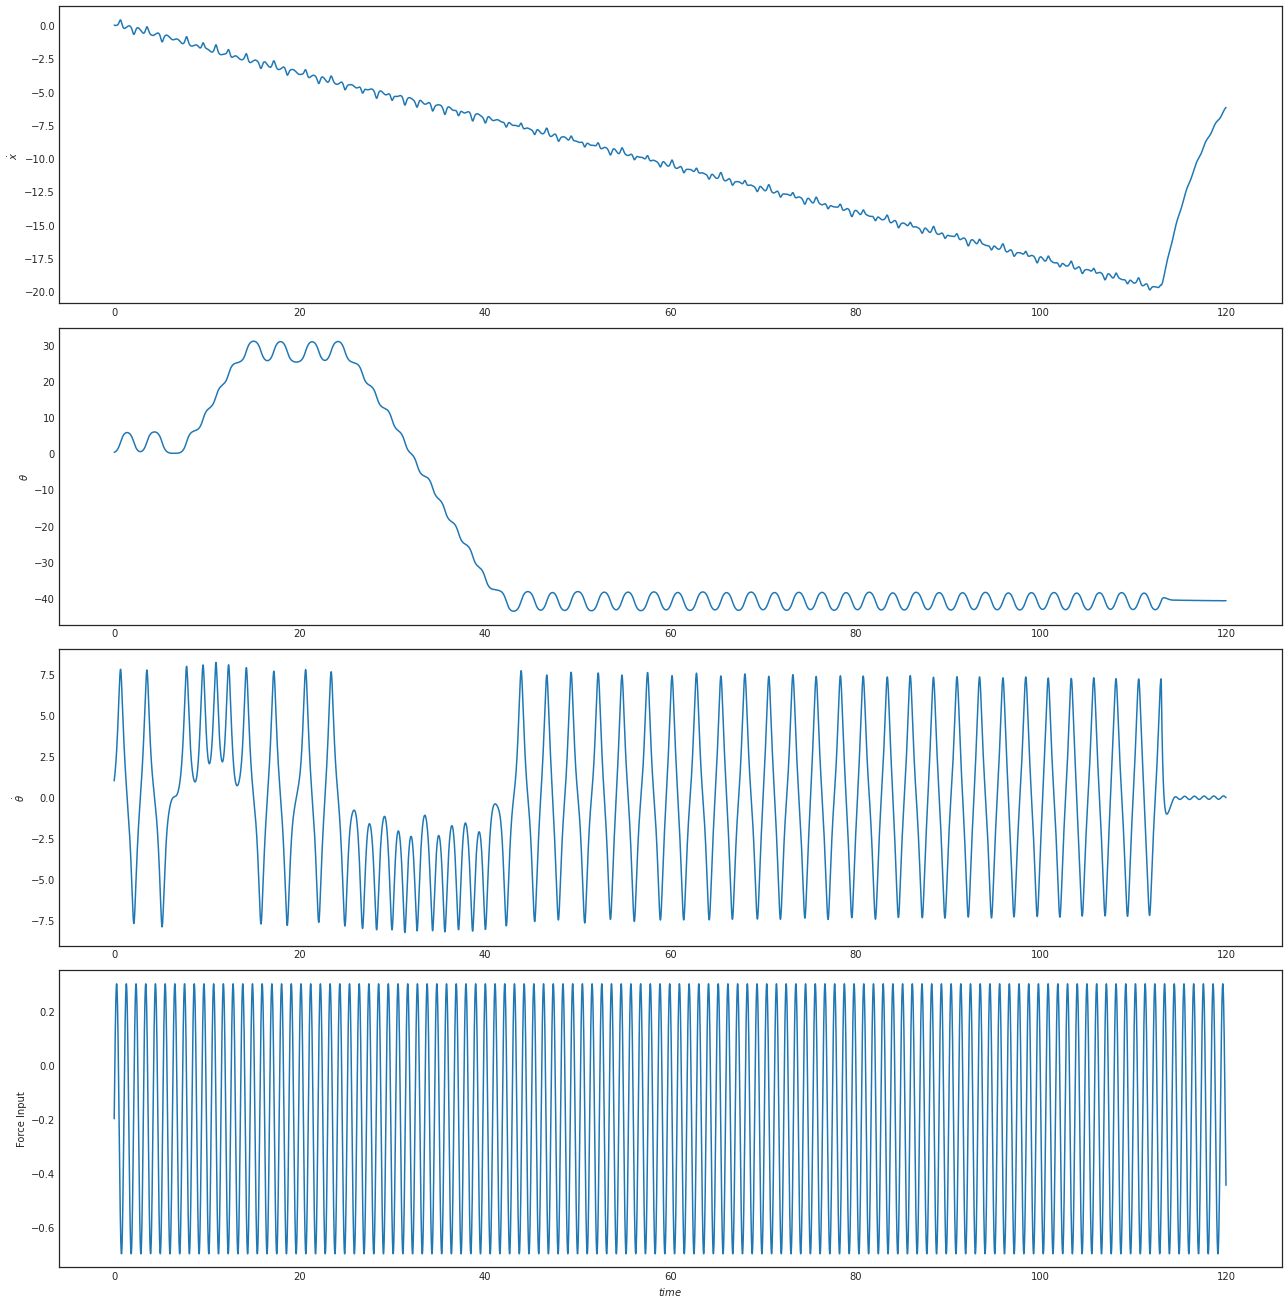

In [3]:
# Converting to Numpy Arrays for Plotting
theta_dd_sim = np.array(theta_dd_sim)
theta_d_sim = np.array(theta_d_sim)
theta_sim = np.array(theta_sim)
x_dd_sim = np.array(x_dd_sim)
x_d_sim = np.array(x_d_sim)
x_sim = np.array(x_sim)

dt = 0.01
noOfSteps = 12000
timeSteps = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False) # for plotting 

timeSteps = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False)

startTraj = 0
endTraj = 12000

# Plotting 
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)

fig.set_figheight(18)
fig.set_figwidth(18)

#ax1.plot(timeSteps[startTraj:endTraj], x_sim[startTraj:endTraj])
#ax1.set_title("x")
ax1.plot(timeSteps[startTraj:endTraj], x_d_sim[startTraj:endTraj])
ax1.set_ylabel(r"$\dot{x}$")
#ax3.plot(timeSteps[startTraj:endTraj], x_dd_sim[startTraj:endTraj])
#ax3.set_title("x_DotDot")
#axs[1, 0].sharex(axs[0, 0])
ax2.plot(timeSteps[startTraj:endTraj], theta_sim[startTraj:endTraj])
ax2.set_ylabel(r"$\theta$")
ax3.plot(timeSteps[startTraj:endTraj], theta_d_sim[startTraj:endTraj])
ax3.set_ylabel(r"$\dot{\theta}$")
ax4.plot(timeSteps[startTraj:endTraj], forceIn[startTraj:endTraj])
ax4.set_ylabel("Force Input")
#ax6.plot(timeSteps[startTraj:endTraj], theta_dd_sim[startTraj:endTraj])
#ax6.set_title("theta_DotDot")
fig.tight_layout()
plt.xlabel("$time$")
#plt.savefig('../../../Results/noisyCase/GPwithGPy/featuresAll.png')

# GPy

In [4]:
st_Traj = 0
en_Traj = 8000 # 2307 # 9405

# Training Input (Standardized)
theta_sim_mean = theta_sim[st_Traj:en_Traj].mean()
theta_sim_stdev = theta_sim[st_Traj:en_Traj].std()

theta_d_sim_mean = theta_d_sim[st_Traj:en_Traj].mean()
theta_d_sim_stdev = theta_d_sim[st_Traj:en_Traj].std()

x_d_sim_mean = x_d_sim[st_Traj:en_Traj].mean()
x_d_sim_stdev = x_d_sim[st_Traj:en_Traj].std()

forceIn_mean = forceIn[st_Traj:en_Traj].mean()
forceIn_stdev = forceIn[st_Traj:en_Traj].std()  

# Training Output (Standardized)
theta_dd_sim_mean = theta_dd_sim[st_Traj:en_Traj].mean()
theta_dd_sim_stdev = theta_dd_sim[st_Traj:en_Traj].std()  

x_dd_sim_mean = x_dd_sim[st_Traj:en_Traj].mean()
x_dd_sim_stdev = x_dd_sim[st_Traj:en_Traj].std() 

X_train = np.stack(((theta_sim[st_Traj:en_Traj]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[st_Traj:en_Traj]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[st_Traj:en_Traj]-x_d_sim_mean)/x_d_sim_stdev,(forceIn[st_Traj:en_Traj]-forceIn_mean)/forceIn_stdev), axis=1)

Y_train_theta = ((theta_dd_sim[st_Traj:en_Traj]-theta_dd_sim_mean)/theta_dd_sim_stdev).reshape(-1,1)  # RMSE(A)
Y_train_x = ((x_dd_sim[st_Traj:en_Traj]-x_dd_sim_mean)/x_dd_sim_stdev).reshape(-1,1)  # RMSE(V)

# Testing Output (Standardized)

Y_test_theta = ((theta_dd_sim[en_Traj:]-theta_dd_sim_mean)/theta_dd_sim_stdev).reshape(-1,1)  # RMSE(A)
Y_test_x = ((x_dd_sim[en_Traj:]-x_dd_sim_mean)/x_dd_sim_stdev).reshape(-1,1)  # RMSE(V)

X_prior = np.stack(((theta_sim-theta_sim_mean)/theta_sim_stdev,(theta_d_sim-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim-x_d_sim_mean)/x_d_sim_stdev,(forceIn-forceIn_mean)/forceIn_stdev), axis=1) # Prior

In [6]:
def train_out(Y_train):    
    noise = 0.017

    #k1 = GPy.kern.ExpQuad(input_dim=3)
    #k2 = GPy.kern.Exponential(input_dim=3)

    #myKernel = k1*k2
    myKernel = GPy.kern.Matern32(input_dim=4, ARD=False)
    gpr = GPy.models.GPRegression(X_train, Y_train, kernel=myKernel)

    # Fix the noise variance to known value 
    gpr.Gaussian_noise.variance = noise**2
    gpr.Gaussian_noise.variance.fix()

    # Run optimization
    gpr.optimize()

    # Display optimized parameter values
    display(gpr)
    return gpr

In [7]:
gpr_th = train_out(Y_train_theta)
gpr_x = train_out(Y_train_x)

mu_theta, cov_theta = gpr_th.predict(X_prior)
np.save('../../learnedModels/noisyCase/GPwithGPy/GP_Mat52_Theta(ARDf).npy', gpr_th.param_array)

mu_x, cov_x = gpr_x.predict(X_prior)
np.save('../../learnedModels/noisyCase/GPwithGPy/GP_Mat52_x(ARDf).npy', gpr_x.param_array)

GP_regression.,value,constraints,priors
Mat32.variance,32015.731315745477,+ve,
Mat32.lengthscale,20.437373849224816,+ve,
Gaussian_noise.variance,0.00028900000000000003,+ve fixed,


GP_regression.,value,constraints,priors
Mat32.variance,222523.87659459433,+ve,
Mat32.lengthscale,36.14222031312155,+ve,
Gaussian_noise.variance,0.00028900000000000003,+ve fixed,


In [10]:
#mu_theta, cov_theta = load_gpr_th.predict(X_prior)
#mu_x, cov_x = load_gpr_x.predict(X_prior)

In [8]:
gpr_x.Mat32.lengthscale

index,GP_regression.Mat32.lengthscale,constraints,priors
[0],36.14222031,+ve,


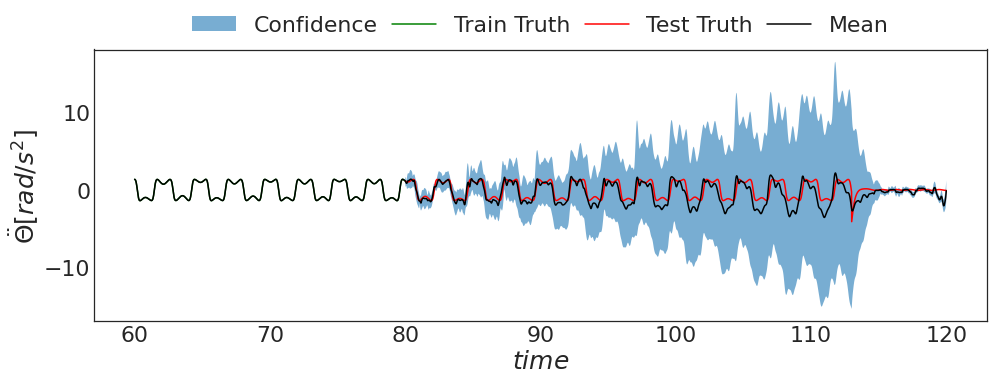

In [12]:
mu = mu_theta.ravel()
uncertainty = 1.96 * np.sqrt(cov_theta).reshape(-1)

start_Traj = 6000
end_Traj = 12000
train_test_split = 8000

fig = plt.figure() 

gs = fig.add_gridspec(1)
ax = gs.subplots(sharex=True)

fig.set_figheight(5)
fig.set_figwidth(16)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=22)    # fontsize of the tick labels
plt.rc('ytick', labelsize=22)    # fontsize of the tick labels
plt.rc('legend', fontsize=22)    # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title

ax.fill_between(timeSteps[start_Traj:end_Traj], mu[start_Traj:end_Traj] + uncertainty[start_Traj:end_Traj], mu[start_Traj:end_Traj] - uncertainty[start_Traj:end_Traj], alpha=0.6)
ax.plot(timeSteps[start_Traj:train_test_split], Y_train_theta[start_Traj:], 'g')
ax.plot(timeSteps[train_test_split:end_Traj], Y_test_theta[:end_Traj-train_test_split], 'r')
ax.plot(timeSteps[start_Traj:end_Traj], mu[start_Traj:end_Traj], 'k')
ax.set_ylabel(r"$\ddot{\Theta}[rad/s^2]$")

ax.legend(('Confidence', 'Train Truth', 'Test Truth', 'Mean'), bbox_to_anchor=(0.1,1.02,0.8,0.2), mode='expand', loc='lower left', ncol=4, borderaxespad=0, shadow=False)
plt.xlabel("$time$")
#plt.savefig('../../../Results/noisyCase/GPwithGPy/GP_Mat52_Theta(ARDf).png')
plt.show()

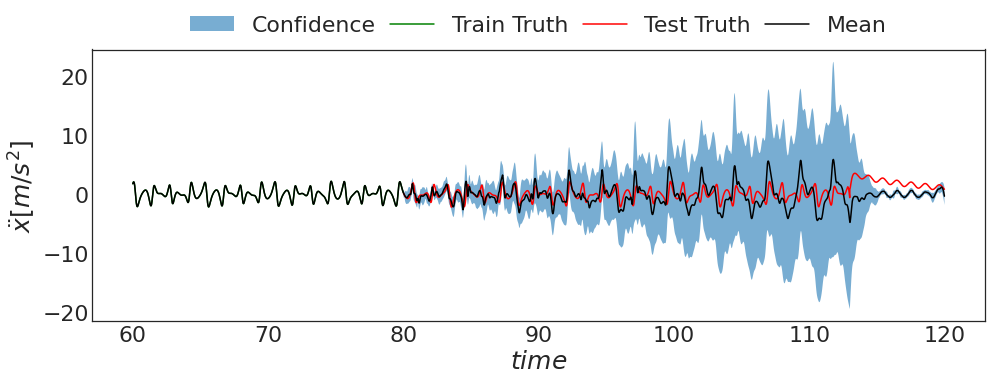

In [13]:
mu = mu_x.ravel()
uncertainty = 1.96 * np.sqrt(cov_x).reshape(-1)

start_Traj = 6000
end_Traj = 12000
train_test_split = 8000

fig = plt.figure() 

gs = fig.add_gridspec(1)
ax = gs.subplots(sharex=True)

fig.set_figheight(5)
fig.set_figwidth(16)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=22)    # fontsize of the tick labels
plt.rc('ytick', labelsize=22)    # fontsize of the tick labels
plt.rc('legend', fontsize=22)    # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title

ax.fill_between(timeSteps[start_Traj:end_Traj], mu[start_Traj:end_Traj] + uncertainty[start_Traj:end_Traj], mu[start_Traj:end_Traj] - uncertainty[start_Traj:end_Traj], alpha=0.6)
ax.plot(timeSteps[start_Traj:train_test_split], Y_train_x[start_Traj:], 'g')
ax.plot(timeSteps[train_test_split:end_Traj], Y_test_x[:end_Traj-train_test_split], 'r')
ax.plot(timeSteps[start_Traj:end_Traj], mu[start_Traj:end_Traj], 'k')

ax.set_ylabel(r"$\ddot{x}[m/s^2]$")
ax.legend(('Confidence', 'Train Truth', 'Test Truth', 'Mean'), bbox_to_anchor=(0.1,1.02,0.8,0.2), mode='expand', loc='lower left', ncol=4, borderaxespad=0, shadow=False)
plt.xlabel("$time$")
#plt.savefig('../../../Results/noisyCase/GPwithGPy/GP_Mat52_x(ARDf).png')
plt.show()

# Testing

In [5]:
# Model creation, without initialization:
#k1 = GPy.kern.ExpQuad(input_dim=3)
#k2 = GPy.kern.Exponential(input_dim=3)
myKernel = GPy.kern.RatQuad(input_dim=4, ARD=True)
#myKernel = k1+k2
load_gpr_th = GPy.models.GPRegression(X_train, Y_train_theta, kernel=myKernel, initialize=False)
load_gpr_th.update_model(False) # do not call the underlying expensive algebra on load
load_gpr_th.initialize_parameter() # Initialize the parameters (connect the parameters up)
load_gpr_th[:] = np.load('../../learnedModels/noisyCase/GPwithGPy/GP_RatQuad_Theta.npy') # Load the parameters
load_gpr_th.update_model(True) # Call the algebra only once
print(load_gpr_th)


Name : GP regression
Objective : -24408.322774677043
Number of Parameters : 7
Number of Optimization Parameters : 7
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  RatQuad.variance         |       65.07826806904367  |      +ve      |        
  RatQuad.lengthscale      |                    (4,)  |      +ve      |        
  RatQuad.power            |     0.06944649395796329  |      +ve      |        
  Gaussian_noise.variance  |  0.00028900000000000003  |      +ve      |        


In [6]:
load_gpr_th.RatQuad.lengthscale

index,GP_regression.RatQuad.lengthscale,constraints,priors
[0],0.06761293,+ve,
[1],408.95254683,+ve,
[2],238.84008725,+ve,
[3],44.66367933,+ve,


In [7]:
# Model creation, without initialization:
#k1 = GPy.kern.ExpQuad(input_dim=3)
#k2 = GPy.kern.Exponential(input_dim=3)
myKernel = GPy.kern.RatQuad(input_dim=4, ARD=True)
#myKernel = k1+k2
load_gpr_x = GPy.models.GPRegression(X_train, Y_train_x, kernel=myKernel, initialize=False)
load_gpr_x.update_model(False) # do not call the underlying expensive algebra on load
load_gpr_x.initialize_parameter() # Initialize the parameters (connect the parameters up)
load_gpr_x[:] = np.load('../../learnedModels/noisyCase/GPwithGPy/GP_RatQuad_x.npy') # Load the parameters
load_gpr_x.update_model(True) # Call the algebra only once
print(load_gpr_x)


Name : GP regression
Objective : -24000.846505112502
Number of Parameters : 7
Number of Optimization Parameters : 7
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  RatQuad.variance         |       8416.355334745158  |      +ve      |        
  RatQuad.lengthscale      |                    (4,)  |      +ve      |        
  RatQuad.power            |     0.03909584473002484  |      +ve      |        
  Gaussian_noise.variance  |  0.00028900000000000003  |      +ve      |        


In [8]:
load_gpr_x.RatQuad.lengthscale

index,GP_regression.RatQuad.lengthscale,constraints,priors
[0],0.09195937,+ve,
[1],5.56897863,+ve,
[2],13284.79935156,+ve,
[3],136.29453066,+ve,


In [17]:
trunc_st = 0
trunc_en = 9000

X_prior = np.stack(((theta_sim[trunc_st:trunc_en]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[trunc_st:trunc_en]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[trunc_st:trunc_en]-x_d_sim_mean)/x_d_sim_stdev,(forceIn[trunc_st:trunc_en]-forceIn_mean)/forceIn_stdev), axis=1)
#X_prior = np.stack(((theta_sim[:-1]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[:-1]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[:-1]-x_d_sim_mean)/x_d_sim_stdev,(forceIn-forceIn_mean)/forceIn_stdev), axis=1) # Prior

In [18]:
mu_th_dd = np.zeros(X_prior.shape[0])
cov_th_dd = np.zeros((X_prior.shape[0], X_prior.shape[0]))
gp_th_d = np.zeros(X_prior.shape[0])
gp_th = np.zeros(X_prior.shape[0])

mu_x_dd = np.zeros(X_prior.shape[0])
cov_x_dd = np.zeros((X_prior.shape[0], X_prior.shape[0]))
gp_x_d = np.zeros(X_prior.shape[0])
gp_x = np.zeros(X_prior.shape[0])

mu_th_dd[0] =  theta_dd_sim[trunc_st]
gp_th_d[0] = theta_d_sim[trunc_st]
gp_th[0] = theta_sim[trunc_st]
mu_x_dd[0] = x_dd_sim[trunc_st]
gp_x_d[0] = x_d_sim[trunc_st]
gp_x[0] = x_sim[trunc_st]

for k in range(X_prior.shape[0]):
    if k != X_prior.shape[0]-1:
        mu_th_dd[k+1], cov_th_dd[k+1,:] = load_gpr_th.predict(X_prior[k,:].reshape(1,-1))
        unstand_acc = mu_th_dd[k+1]*theta_dd_sim_stdev + theta_dd_sim_mean
        gp_th_d[k+1] = gp_th_d[k]+(unstand_acc)*(dt)
        #X_prior[k+1,1] = (gp_th_d[k+1]-theta_d_sim_mean) / theta_d_sim_stdev
        gp_th[k+1] = gp_th[k] + (gp_th_d[k+1] + gp_th_d[k])*(dt) / 2 #+ (0.5)*(mu_s[k])*(dt**2)
        #X_prior[k+1,0] = (gp_th[k+1]-theta_sim_mean) / theta_sim_stdev
        mu_x_dd[k+1], cov_x_dd[k+1,:] = load_gpr_x.predict(X_prior[k,:].reshape(1,-1))
        unstand_x = mu_x_dd[k+1]*x_dd_sim_stdev + x_dd_sim_mean
        gp_x_d[k+1] = gp_x_d[k]+(unstand_x)*(dt)
        #X_prior[k+1,2] = (gp_x_d[k+1]-x_d_sim_mean) / x_d_sim_stdev
        gp_x[k+1] = gp_x[k] + (gp_x_d[k+1] + gp_x_d[k])*(dt) / 2 #+ (0.5)*(mu_s[k])*(dt**2)

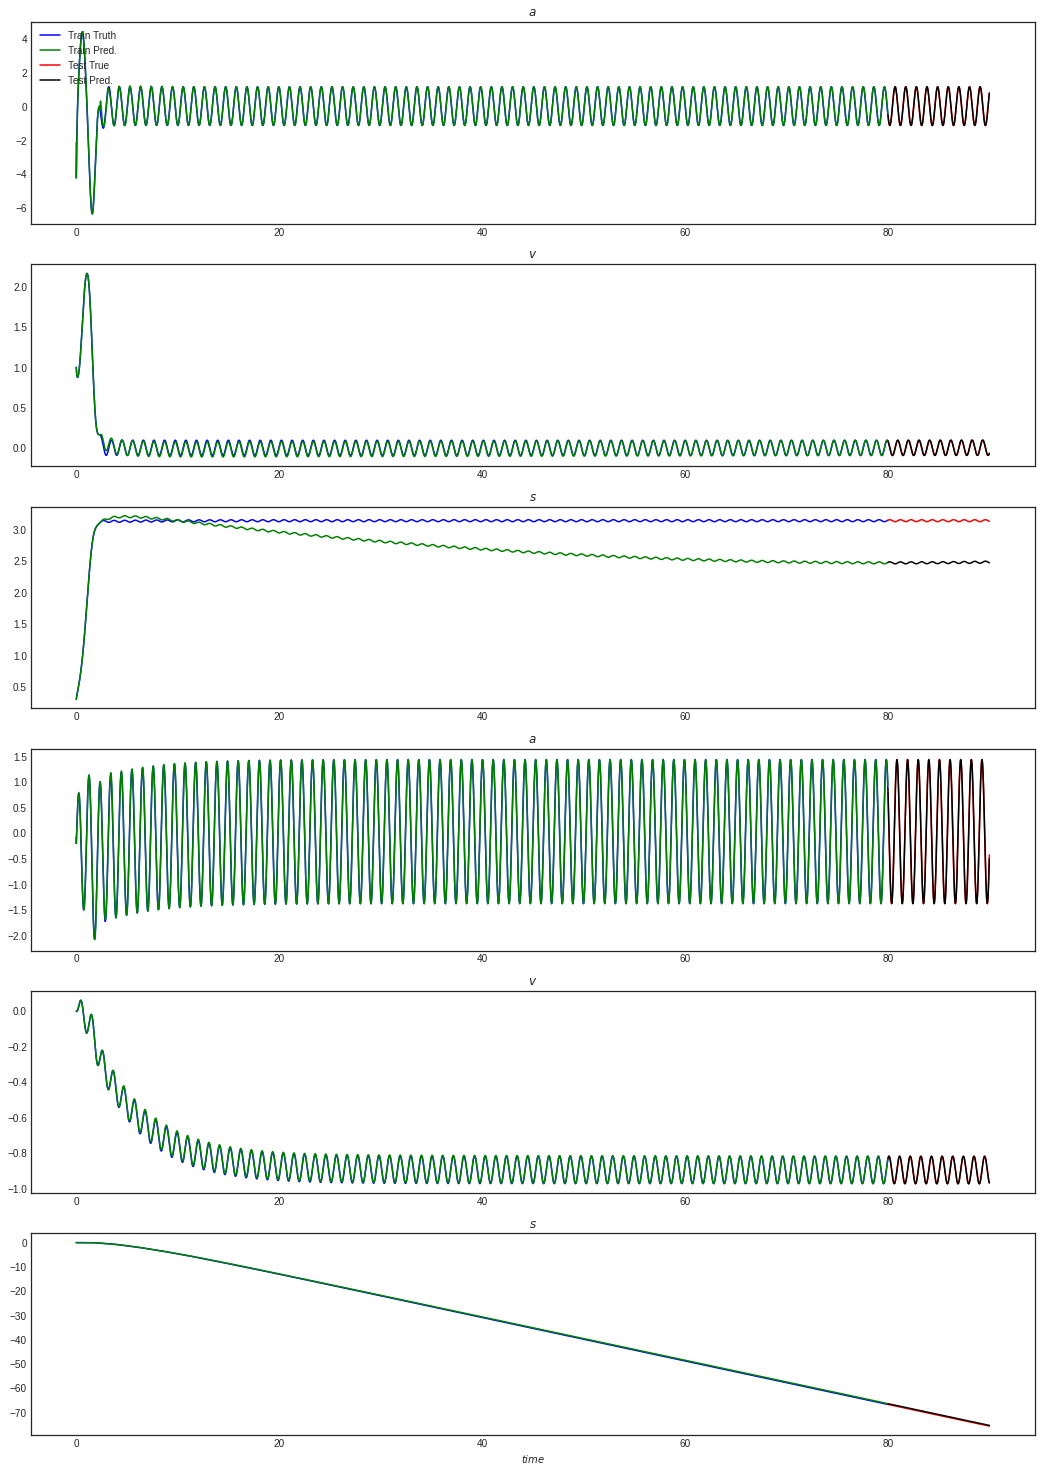

In [19]:
# Plotting 
train_test_split = 8000 # define it above later on 

st_Trajec = trunc_st
mid_Trajec = train_test_split
en_Trajec = trunc_en

# For predictions
mid_pred = train_test_split - trunc_st 

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6) 

fig.set_figheight(26)
fig.set_figwidth(18)

uncertainty_th = 1.96 * np.sqrt(np.diag(cov_th_dd))
uncertainty_x = 1.96 * np.sqrt(np.diag(cov_x_dd))

ax1.fill_between(timeSteps[st_Trajec:en_Trajec], mu_th_dd + uncertainty_th, mu_th_dd - uncertainty_th, alpha=0.3)
b1, = ax1.plot(timeSteps[st_Trajec:mid_Trajec], Y_train_theta[st_Trajec:mid_Trajec], "b")
g1, = ax1.plot(timeSteps[st_Trajec:mid_Trajec], mu_th_dd[:mid_pred], "g")
r1, = ax1.plot(timeSteps[mid_Trajec:en_Trajec], Y_test_theta[:en_Trajec-mid_Trajec], "r")
k1, = ax1.plot(timeSteps[mid_Trajec:en_Trajec], mu_th_dd[mid_pred:], "k")
ax1.set_title('$a$')

ax2.plot(timeSteps[st_Trajec:mid_Trajec], theta_d_sim[st_Trajec:mid_Trajec], "b")
ax2.plot(timeSteps[st_Trajec:mid_Trajec], gp_th_d[:mid_pred], "g")
ax2.plot(timeSteps[mid_Trajec:en_Trajec], theta_d_sim[mid_Trajec:en_Trajec], "r")
ax2.plot(timeSteps[mid_Trajec:en_Trajec], gp_th_d[mid_pred:], "k")
ax2.set_title('$v$')

ax3.plot(timeSteps[st_Trajec:mid_Trajec], theta_sim[st_Trajec:mid_Trajec], "b")
ax3.plot(timeSteps[st_Trajec:mid_Trajec], gp_th[:mid_pred], "g")
ax3.plot(timeSteps[mid_Trajec:en_Trajec], theta_sim[mid_Trajec:en_Trajec], "r")
ax3.plot(timeSteps[mid_Trajec:en_Trajec], gp_th[mid_pred:], "k")
ax3.set_title('$s$')

ax4.fill_between(timeSteps[st_Trajec:en_Trajec], mu_x_dd + uncertainty_x, mu_x_dd - uncertainty_x, alpha=0.3)
ax4.plot(timeSteps[st_Trajec:mid_Trajec], Y_train_x[st_Trajec:], "b")
ax4.plot(timeSteps[st_Trajec:mid_Trajec], mu_x_dd[:mid_pred], "g")
ax4.plot(timeSteps[mid_Trajec:en_Trajec], Y_test_x[:en_Trajec-mid_Trajec], "r")
ax4.plot(timeSteps[mid_Trajec:en_Trajec], mu_x_dd[mid_pred:], "k")
ax4.set_title('$a$')

ax5.plot(timeSteps[st_Trajec:mid_Trajec], x_d_sim[st_Trajec:mid_Trajec], "b")
ax5.plot(timeSteps[st_Trajec:mid_Trajec], gp_x_d[:mid_pred], "g")
ax5.plot(timeSteps[mid_Trajec:en_Trajec], x_d_sim[mid_Trajec:en_Trajec], "r")
ax5.plot(timeSteps[mid_Trajec:en_Trajec], gp_x_d[mid_pred:], "k")
ax5.set_title('$v$')

ax6.plot(timeSteps[st_Trajec:mid_Trajec], x_sim[st_Trajec:mid_Trajec], "b")
ax6.plot(timeSteps[st_Trajec:mid_Trajec], gp_x[:mid_pred], "g")
ax6.plot(timeSteps[mid_Trajec:en_Trajec], x_sim[mid_Trajec:en_Trajec], "r")
ax6.plot(timeSteps[mid_Trajec:en_Trajec], gp_x[mid_pred:], "k")
ax6.set_title('$s$')

ax1.legend((b1, g1, r1, k1), ('Train Truth', 'Train Pred.', 'Test True', 'Test Pred.'), loc='upper left', shadow=False)
plt.xlabel("$time$")
#plt.savefig('GP_Exp_Stand_JIANG(A).png')
plt.show()

# Distance Plotting 

In [14]:
def dist_plot(X_prior, lenScale: list):
    start = 8000
    testPts = 4000
    dist_all = np.zeros((testPts,8000))    
    for i in range(testPts):
        dist_all[i,:] = np.divide(np.square(X_prior[start+i,0]-X_prior[:8000,0]),np.square(lenScale[0]))\
                  + np.divide(np.square(X_prior[start+i,1]-X_prior[:8000,1]),np.square(lenScale[1]))\
                  + np.divide(np.square(X_prior[start+i,2]-X_prior[:8000,2]),np.square(lenScale[2]))\
                  + np.divide(np.square(X_prior[start+i,3]-X_prior[:8000,3]),np.square(lenScale[3]))
    return dist_all 

In [15]:
lenScaleRatQuadTh = [0.067,408.95,238.84,44.66]
#lenScaleRatQuadTh = [408,400,0.067,238]
lenScaleRatQuadx = [0.091,5.568,13284.799,136.294]
lenScaleExpTh = [2.69,5703.49,7231.76,5167.42]
lenScaleExpx = [140.79,28705.40,23651.49,26180.34]
lenScaleMat32Th = [6.32,51189.98,10518.79,3380.92]
lenScaleMat32x = [28.05,1105.75,51014006.48,71869.47]
lenScaleMat52Th = [0.37,710.66,664.84,201.59]
#lenScaleMat52x = [0.56,24.56,17099.63,1135.88]
lenScaleMat52x = [36.14,36.14,36.14,36.14]

distRatQuadTh = dist_plot(X_prior,lenScaleRatQuadTh)
distRatQuadx = dist_plot(X_prior,lenScaleRatQuadx)
distExpTh = dist_plot(X_prior,lenScaleExpTh)
distExpx = dist_plot(X_prior,lenScaleExpx)
distMat32Th = dist_plot(X_prior,lenScaleMat32Th)
distMat32x = dist_plot(X_prior,lenScaleMat32x)
distMat52Th = dist_plot(X_prior,lenScaleMat52Th)
distMat52x = dist_plot(X_prior,lenScaleMat52x)

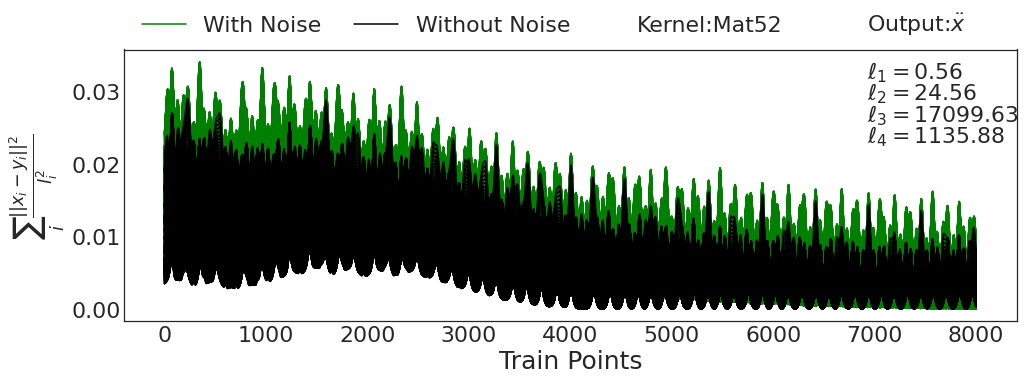

In [16]:
trainPts = np.arange(8000)+1
fig = plt.figure() 

gs = fig.add_gridspec(1)
ax = gs.subplots(sharex=True)

fig.set_figheight(5)
fig.set_figwidth(16)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=22)    # fontsize of the tick labels
plt.rc('ytick', labelsize=22)    # fontsize of the tick labels
plt.rc('legend', fontsize=22)    # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title

for i in range(4000):
    if i<3300:
        g1, = ax.plot(trainPts[:8000], distMat52x[i,:], 'g')
    else:    
        k1, = ax.plot(trainPts[:8000], distMat52x[i,:], 'k')
plt.figtext(0.77,0.8,  r"$\ell_1=0.56$")
plt.figtext(0.77,0.74, r"$\ell_2=24.56$")
plt.figtext(0.77,0.68, r"$\ell_3=17099.63$")
plt.figtext(0.77,0.62, r"$\ell_4=1135.88$")
plt.figtext(0.57,0.93, "Kernel:Mat52" )
plt.figtext(0.77,0.93, "Output:"r"$\ddot{x}$")

#plt.figtext(0.70,0.93, )
ax.legend((g1, k1), ('With Noise', 'Without Noise'), bbox_to_anchor=(0.01,1.02,0.5,0.2), mode='expand', loc='lower left', ncol=2, borderaxespad=0, shadow=False)

ax.set_ylabel(r"$\sum_{i}\frac{||x_{i}-y_{i}||^{2}}{l_{i}^2}$")
plt.xlabel("Train Points")
#plt.savefig('../../../Results/noisyCase/GPwithGPy/distMat52x.png')
plt.show()

In [77]:
kjh = np.divide(np.square(X_prior[8000:8000+1,0]-X_prior[:8000,0]),19) +\
      np.divide(np.square(X_prior[8000:8000+1,1]-X_prior[:8000,1]),10)

In [78]:
trainPts = np.arange(8000)